In [30]:
from utils import load_data
import pandas as pd
import numpy as np
from scipy import sparse
import implicit
from sklearn.model_selection import train_test_split
from implicit import evaluation
import matplotlib.pyplot as plt

In [2]:
df = load_data("./active1000")
df["time"] = df["time"].apply(
    lambda date: pd.Timestamp(date, unit="s", tz="Europe/Oslo")
)
df.drop(index=df[df.url == "http://adressa.no"].index, inplace=True)


In [3]:
def dataframe_to_user_item_matrix(df):
    df = df.drop_duplicates(subset=['userId', 'documentId'])
    df = df.sort_values(by=['userId', 'time'])

    n_users = df['userId'].nunique()
    n_items = df['documentId'].count()

    ratings = np.zeros((n_users, n_items))

    new_user = df['userId'].values[1:] != df['userId'].values[:-1]
    new_user = np.r_[True, new_user]

    df['uid'] = np.cumsum(new_user)
    item_ids = df['documentId'].unique().tolist()

    new_df = pd.DataFrame({'documentId': item_ids, 'tid': range(1, len(item_ids) + 1)})

    df = pd.merge(df, new_df, on='documentId', how='outer')
    user_id_document_df = df[['documentId', 'uid', 'userId']]
    df_ext = df[['uid', 'tid']]

    users_df = df["uid"].unique()
    user_indexes = set()

    for row in df_ext.itertuples():
        ratings[row[1] - 1, row[2] - 1] = 1.0

        if row[1] in users_df:
            user_indexes.add(row[1] - 1)

    print(f"Matrix created with {ratings.shape[0]} users and {ratings.shape[1]} items")
    return ratings, user_indexes, item_ids, user_id_document_df

user_item_data, user_indexes, item_ids, user_id_document_df = dataframe_to_user_item_matrix(df)

user_item_sparse_matrix = sparse.csr_matrix(user_item_data)
train_data, test_data = train_test_split(user_item_sparse_matrix, random_state=23, test_size=0.25)

Matrix created with 1000 users and 679355 items


In [12]:
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(train_data)

100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


In [13]:
recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=50)
ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
print(list(zip(ids, list(recommendations[1]))))

[('aa6a5862cb2ae9fb8996f35a692192559b9083e1', 0.81256396), ('1ae48cc9bf00e7a94c6fb70e7beb74ee9b926998', 0.7481092), ('0a8c6555c75b8fd530be97356c8b62f6a6a4ad83', 0.7294731), ('cd625da5a4f18ba4912ce7c6a50340b364c2c7f1', 0.71077603), ('50c3b54c898d2c76681b4e4c02bad53b7a26b01b', 0.6657554), ('0bad5f842d38601fe714f625d46be941fb27f28c', 0.66435087), ('b85abfb0937cf948a48ca22758a4e03407bc3fcc', 0.6485416), ('7b37701ba1916986c0d63c074df278f9ea9117cb', 0.584767), ('55cb612b1b7f09e817909fb95156ef74f1711b70', 0.58449745), ('794793820080e2f3949a4a8209de055297004031', 0.5767855), ('01e4d502d724e6206166c33c0ad50a456282124f', 0.5730588), ('594d6458ecbd19fbb0657314bb5c742606ef57b9', 0.57183325), ('701d08c9626c66acf1bdb39454c3c3de4db5c8e1', 0.5632589), ('92cf23b4733e4ce19f012cbf2a0db25b0a7dd02f', 0.5602349), ('2febaa0c1a2bb66a3dda745c33ba3da7cc81a55b', 0.5600884), ('b9ad78ebb5acf15b97a2172aae104903e2a41afe', 0.55728364), ('ac5205a07fdf4c863910b102fb7e59dc50cbd440', 0.5561685), ('c065a4298b0dc55060e4dc6

In [17]:

def evaluate_recall(ids, user_index):
    user_id = user_id_document_df[user_id_document_df.uid == user_index].iloc[0]['userId']
    true_positive = 0
    total = 0
    current_df = user_id_document_df.drop_duplicates(subset=['documentId', 'userId'])
    mask = current_df.userId.apply(lambda x: x == user_id)
    current_df = current_df[mask]

    docs_recommended_properly = []
    docs_not_recommended_properly = []

    for id in ids:
        try:
            if current_df[current_df.documentId == id].documentId.values[0] == id:
                docs_recommended_properly.append(id)
                true_positive += 1
        except:
            docs_not_recommended_properly.append(id)
        total += 1
    false_negative = current_df.count().uid - true_positive
    #print("Recall: " + str(true_positive / (true_positive + false_negative)) + "\n")
    #print("True positives: " + str(docs_recommended_properly))
    #print("False positives: " + str(docs_not_recommended_properly))
    return true_positive / (true_positive + false_negative)
evaluate_recall(ids, 1)
    

0.02073365231259968

In [15]:
evaluation.mean_average_precision_at_k(model, train_data, test_data)

100%|██████████| 250/250 [00:00<00:00, 554.31it/s]


0.27094682539682524

In [25]:
'''
Testing for different recall values on different users
'''
recalls = []
for x in range(0, 20):
    recommendations = model.recommend(x, test_data[x], filter_already_liked_items=True, recalculate_user=True, N=50)
    recalls.append(evaluate_recall(ids, x+1))
print('recalls: ' + str(recalls) + '\n')
print('average recall: ' + str(sum(recalls) / len(recalls)))


recalls: [0.02073365231259968, 0.03682170542635659, 0.025252525252525252, 0.03937007874015748, 0.040973111395646605, 0.04525547445255475, 0.037578288100208766, 0.02127659574468085, 0.03008849557522124, 0.035, 0.047493403693931395, 0.010101010101010102, 0.03180212014134275, 0.024886877828054297, 0.03676470588235294, 0.03547671840354767, 0.04483430799220273, 0.024746906636670417, 0.02962962962962963, 0.03861003861003861]

average recall: 0.032834782295936595


In [26]:
'''
Testing for different recall values on same user
'''
recalls = []
for x in range(0, 20):
    recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=50)
    recalls.append(evaluate_recall(ids, x+1))
print('recalls: ' + str(recalls) + '\n')
print('average recall: ' + str(sum(recalls) / len(recalls)))

recalls: [0.02073365231259968, 0.03682170542635659, 0.025252525252525252, 0.03937007874015748, 0.040973111395646605, 0.04525547445255475, 0.037578288100208766, 0.02127659574468085, 0.03008849557522124, 0.035, 0.047493403693931395, 0.010101010101010102, 0.03180212014134275, 0.024886877828054297, 0.03676470588235294, 0.03547671840354767, 0.04483430799220273, 0.024746906636670417, 0.02962962962962963, 0.03861003861003861]

average recall: 0.032834782295936595


In [35]:
'''
Testing for different recall values on different recommendations for the same user
'''
recalls = []
for x in range(1, 100):
    recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=x)
    recalls.append(evaluate_recall(ids, x+1))
print('recalls: ' + str(recalls) + '\n')
print('average recall: ' + str(sum(recalls) / len(recalls)))


recalls: [0.03682170542635659, 0.025252525252525252, 0.03937007874015748, 0.040973111395646605, 0.04525547445255475, 0.037578288100208766, 0.02127659574468085, 0.03008849557522124, 0.035, 0.047493403693931395, 0.010101010101010102, 0.03180212014134275, 0.024886877828054297, 0.03676470588235294, 0.03547671840354767, 0.04483430799220273, 0.024746906636670417, 0.02962962962962963, 0.03861003861003861, 0.037760416666666664, 0.03096234309623431, 0.041193181818181816, 0.014234875444839857, 0.02, 0.04056795131845842, 0.04025423728813559, 0.042105263157894736, 0.03313253012048193, 0.039832285115303984, 0.04895104895104895, 0.025780189959294438, 0.025048169556840076, 0.03707742639040349, 0.0297029702970297, 0.036585365853658534, 0.029832935560859187, 0.03288672350791717, 0.03291139240506329, 0.05925925925925926, 0.027600849256900213, 0.05154639175257732, 0.04264705882352941, 0.022792022792022793, 0.04073319755600815, 0.04186046511627907, 0.030357142857142857, 0.027149321266968326, 0.02946428571

<BarContainer object of 99 artists>

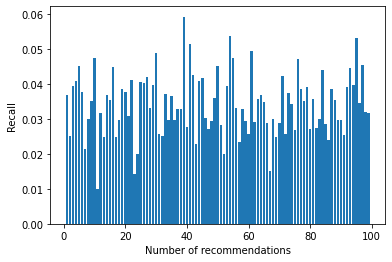

In [39]:
plt.ylabel('Recall')
plt.xlabel('Number of recommendations')
plt.bar([x for x in range(1, 100)], height=recalls, data=recalls)